In [161]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import read_csv
from datetime import datetime

## num_hours_past
how far the model looks into the past

## num_hours_future
how far the model predicts in the future

## train_test_ratio
The first train_test_ratio portion of the data is used as training, the remainder as testing

Change these variables below

In [162]:
num_hours_past = 100
num_hours_future = 1

train_test_ratio = 0.6666666

In [163]:
def get_cols_to_drop(reframed):
    lst = []

    total_length = len(reframed.columns)

    var_idx = list(reframed.columns).index('var1(t)')

    #reframed.columns[num]

    for i in range(var_idx, total_length):
        if i%8 != 0:
            lst.append(reframed.columns[i])
            
    return lst

# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg



def design_network(train_X, tr):
    # design network
    model = Sequential()
    
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    
    #sets output shape
    model.add(Dense(num_hours_future))
    model.compile(loss='mae', optimizer='adam')
    
    return model

In [164]:
'''
dataset = read_csv('PRSA_data_2010.1.1-2014.12.31.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]

dataset.to_csv('pollution.csv')
'''

"\ndataset = read_csv('PRSA_data_2010.1.1-2014.12.31.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)\ndataset.drop('No', axis=1, inplace=True)\n\ndataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']\ndataset.index.name = 'date'\n\ndataset['pollution'].fillna(0, inplace=True)\ndataset = dataset[24:]\n\ndataset.to_csv('pollution.csv')\n"

In [165]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')

In [166]:
target_values = values[:, 0].reshape(-1, 1)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit_transform(target_values)

array([[0.12977867],
       [0.14889336],
       [0.15995975],
       ...,
       [0.01006036],
       [0.00804829],
       [0.01207243]], dtype=float32)

In [167]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, num_hours_past, num_hours_future)

reframed.drop(get_cols_to_drop(reframed), axis=1, inplace=True)
values = reframed.values

In [168]:
num_train_hours = int(len(values)*train_test_ratio)


train = values[:num_train_hours, :]
train_X, train_y = train[:, :-num_hours_past], train[:, -num_hours_future:]

test = values[num_train_hours:, :]
test_X, test_y = test[:, :-num_hours_past], test[:, -num_hours_future:]

In [169]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(29133, 701)
(29133, 1)
(14567, 701)
(14567, 1)


In [170]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(29133, 1, 701) (29133, 1) (14567, 1, 701) (14567, 1)


In [171]:
model = design_network(train_X, train_y)

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 29133 samples, validate on 14567 samples
Epoch 1/50
29133/29133 [==============================] - 3s 98us/step - loss: 0.0707 - val_loss: 0.0590
Epoch 2/50
29133/29133 [==============================] - 1s 51us/step - loss: 0.0628 - val_loss: 0.0608
Epoch 3/50
29133/29133 [==============================] - 2s 58us/step - loss: 0.0606 - val_loss: 0.0584
Epoch 4/50
29133/29133 [==============================] - 2s 53us/step - loss: 0.0591 - val_loss: 0.0614
Epoch 5/50
29133/29133 [==============================] - 1s 49us/step - loss: 0.0582 - val_loss: 0.0644
Epoch 6/50
29133/29133 [==============================] - 2s 60us/step - loss: 0.0577 - val_loss: 0.0589
Epoch 7/50
29133/29133 [==============================] - 2s 63us/step - loss: 0.0573 - val_loss: 0.0582
Epoch 8/50
29133/29133 [==============================] - 1s 51us/step - loss: 0.0569 - val_loss: 0.0573
Epoch 9/50
29133/29133 [==============================] - 2s 52us/step - loss: 0.0569 - val_loss: 0.0572
Epoch

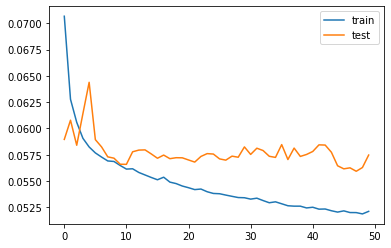

In [172]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [173]:
yhat = model.predict(test_X)

In [174]:
inv_yhat = target_scaler.inverse_transform(yhat)
inv_y = target_scaler.inverse_transform(test_y)

In [175]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 84.393
